## Проект "Сборный проект №2 (мобильное приложение по продаже продуктов питания)" (A/A/B тест)

## Описание проекта

<div style="border:solid blue 2px; padding: 20px">
    
**Я работаю аналитиком в стартапе. Суть стартапа - продажа продуктов питания через мобильное приложение. На основе предоставленных данных мне нужно разобраться, как ведут себя пользователи мобильного приложения.
    Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
    После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.**

## Предобработка данных

### Импорт всех необходимых библиотек для работы

In [20]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import math as mth
from scipy import stats as st
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px

###  Открытие файла с данными

In [21]:
data = pd.read_csv('logs_exp.csv', sep='\t')
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


### Изучение общей информации

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Поиск полных дубликатов

In [23]:
data.duplicated().sum()

413

### Удаление полных дубликатов

In [24]:
data = data.drop_duplicates().reset_index(drop=True)

### Замена названия столбцов на удобные для меня названия

In [25]:
data.columns = ['event_type', 'user_id', 'event_time', 'group']
data.head(1)

,event_type,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,1564029816,246


### Проверка на пропуски и проверка типов данных в столбцах

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_type  243713 non-null  object
 1   user_id     243713 non-null  int64 
 2   event_time  243713 non-null  int64 
 3   group       243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


Пропусков нет - дополнять ничего не нужно.
Типы данных - из четырех столбцов не подходит тип данных в столбце event_time - оно в виде целого числа, а нужен формат дата/время. Переделаем это.

### Смена типа данных в столбце

In [27]:
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')
data.head(1)

,event_type,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_type  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.4+ MB


Теперь все хорошо - типы данных подходят для дальнейшей работы с ними.

Добавлять отдельный столбец с датой и временем мы не будем - мы преобразовали столбец event_time в нужный формат и данный приобрели нужный вид - дата и время

### Добавление отдельного столбца

Добавим отдельный столбец со значением только даты (без времени).

In [29]:
data['event_data']=data['event_time'].dt.date
data.head()

,event_type,user_id,event_time,group,event_data
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


### Обозначение контрольных и экспериментальной группы

Присвоим условные обозначения для названия групп - 246 будет А1, 247 будет А2, 248 будет В

In [30]:
def aab_group(gr):
    if gr==246:
        return 'A1'
    elif gr==247:
        return 'A2'
    elif gr==248:
        return 'B'
    else:
        return 'UnknownGroup'

data['group'] = data['group'].apply(aab_group)
data.head(5)

,event_type,user_id,event_time,group,event_data
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25


## Изучение и проверка данных

### Количество событий в логе

In [31]:
data.count()

event_type    243713
user_id       243713
event_time    243713
group         243713
event_data    243713
dtype: int64

Всего в логе 243 713 строк, т е событий (эта же информация была при вызове функции .info()).
Пропусков нет, так что можно считать так же любой столбец. 

In [32]:
data['event_type'].count()

243713

### Количество пользователей в логе

Сколько всего пользователей в логе?
Для этого посчитайем количество уникальных значений в столбце user_id

In [33]:
data['user_id'].nunique()

7551

В логе отображены события по 7 551 уникальному пользователю

### Количество событий на пользователя

Сколько в среднем событий приходится на одного пользователя?
Для этого общее количество событий разделим на количество уникальных пользователей.

In [34]:
data['event_type'].count()/data['user_id'].nunique()

32.27559263673685

Округлим до целого числа

In [35]:
round(data['event_type'].count()/data['user_id'].nunique())

32

В среднем на каждого пользователя приходится 32 события

Что бы посмотреть распределение количества событий на пользователя и посмотреть на выбросы нам необходимо создать отдельную таблицу

In [36]:
count_event_user = data.groupby('user_id')['event_type'].count()

In [37]:
count_event_user.describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_type, dtype: float64

In [38]:
count_event_user.median()

20.0

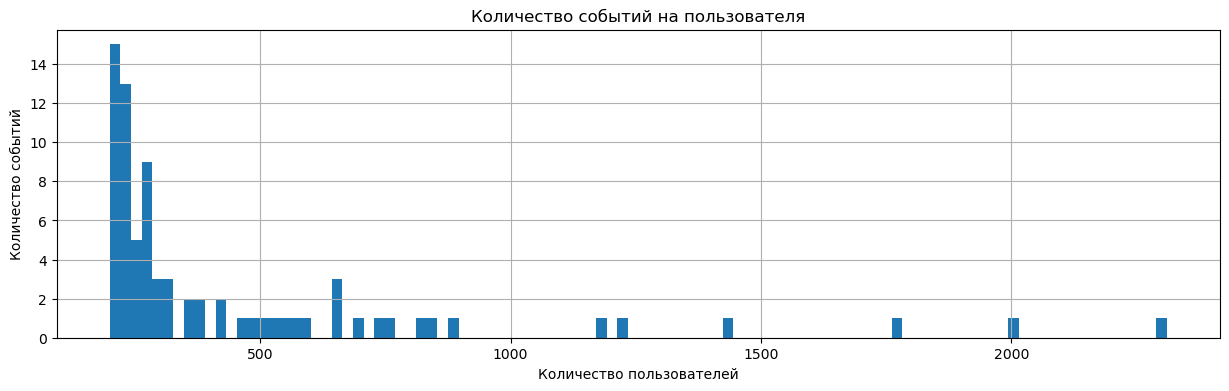

In [39]:
plt.figure(figsize=(15,4))
plt.hist(count_event_user, bins=100, range=(200,2310)) 
plt.title('Количество событий на пользователя')
plt.xlabel('Количество пользователей')
plt.grid()
plt.ylabel('Количество событий');

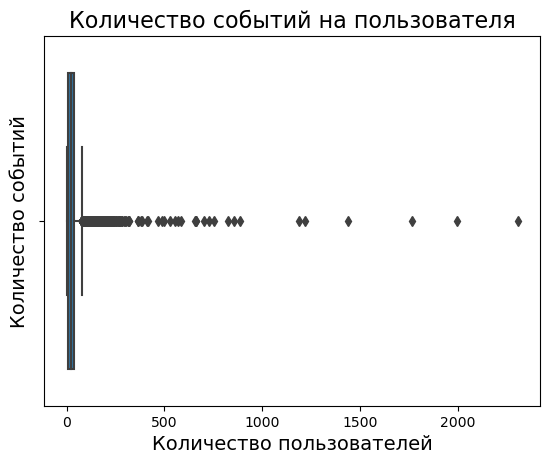

In [40]:
boxplot = sns.boxplot(x=count_event_user)
boxplot.axes.set_title("Количество событий на пользователя", fontsize=16)
boxplot.set_xlabel("Количество пользователей", fontsize=14)
boxplot.set_ylabel("Количество событий", fontsize=14);

### Период времени

#### Максимальная и минимальную дата

In [41]:
min_analysis_date = data['event_data'].min()
max_analysis_date =  data['event_data'].max()  
print(min_analysis_date)
print(max_analysis_date)

2019-07-25
2019-08-07


В файле информация по событиям с 25 июля 2019 года по 7 августа 2019 года.

#### Гистограмма по дате и времени

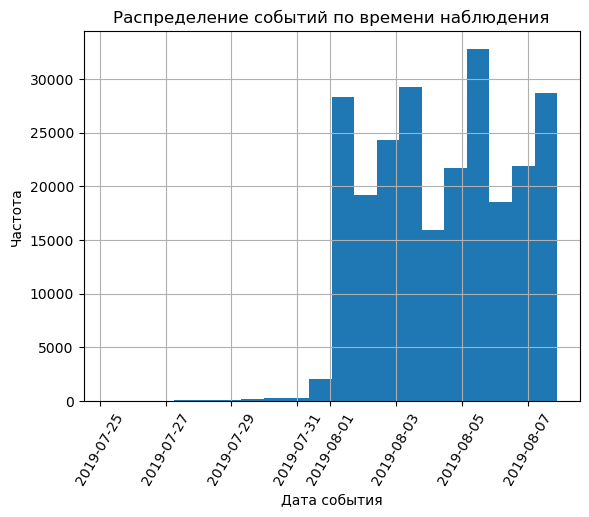

In [42]:
data['event_time'].hist(bins=20)
plt.title('Распределение событий по времени наблюдения')
plt.xlabel('Дата события')
plt.ylabel('Частота')
plt.xticks(rotation=60)
plt.show()

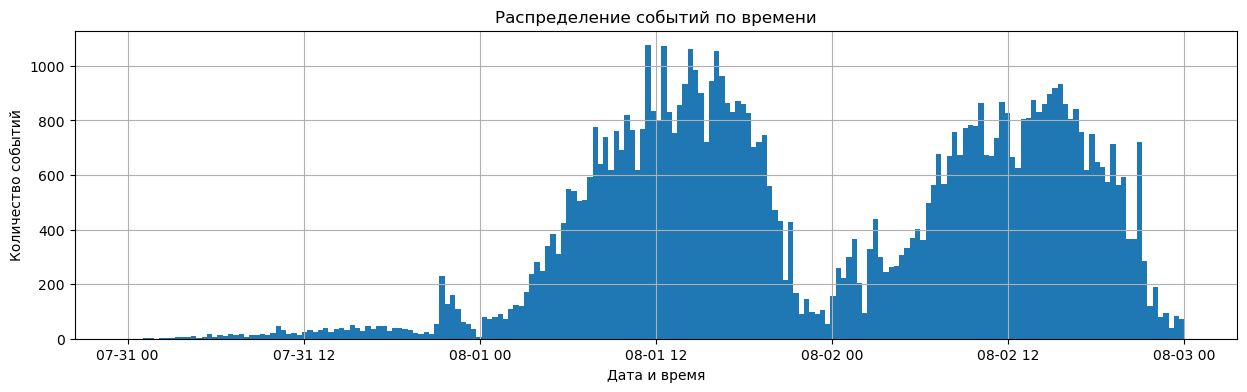

In [43]:
plt.figure(figsize=(15,4))
plt.hist(data['event_time'], bins=200, range=('2019-07-31','2019-08-03'))
plt.xlabel('Дата и время')
plt.grid()
plt.ylabel('Количество событий')
plt.title('Распределение событий по времени');

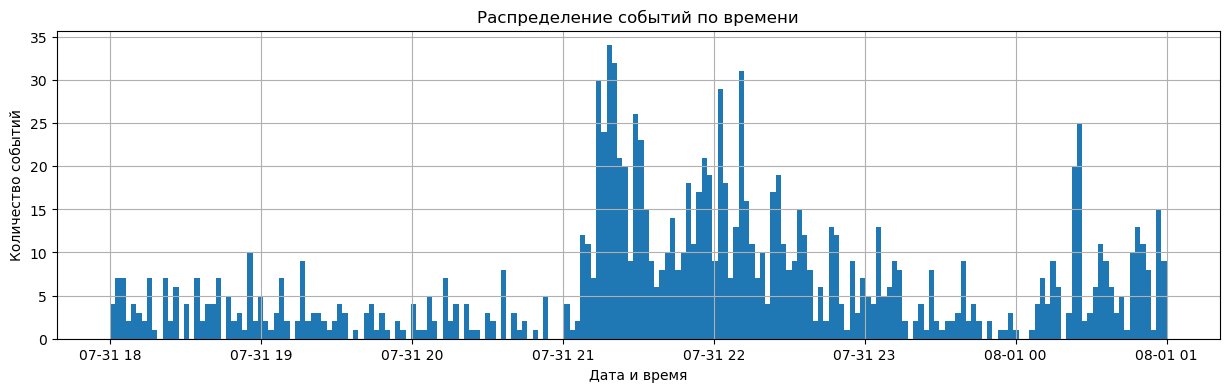

In [44]:
plt.figure(figsize=(15,4))
plt.hist(data['event_time'], bins=200, range=('2019-07-31 18:00:00','2019-08-01 01:00:00'))
plt.xlabel('Дата и время')
plt.grid()
plt.ylabel('Количество событий')
plt.title('Распределение событий по времени');


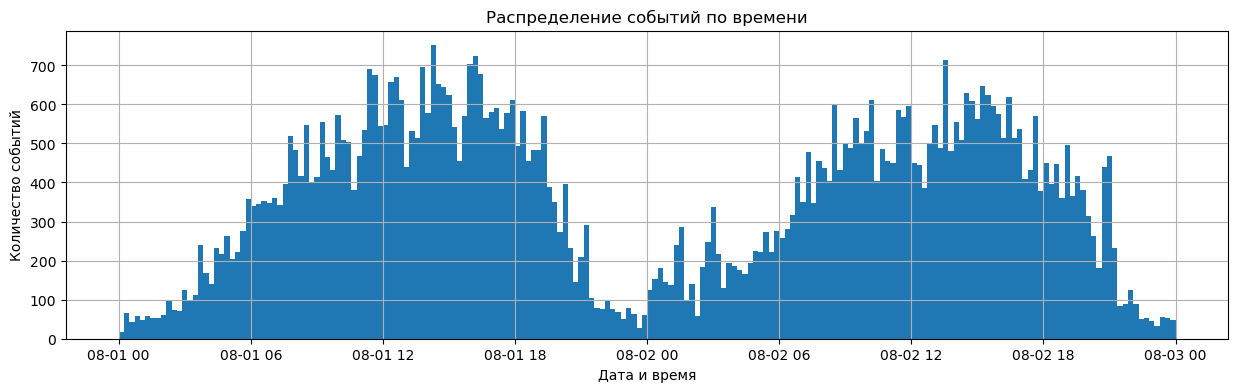

In [45]:
plt.figure(figsize=(15,4))
plt.hist(data['event_time'], bins=200, range=('2019-08-01 00:00:00','2019-08-03 00:00:00'))
plt.xlabel('Дата и время')
plt.grid()
plt.ylabel('Количество событий')
plt.title('Распределение событий по времени');

При подробном рассмотрении данных за 31 июля и 1 августа мы видим точку начала теста - 00:00 1 августа 2019 года.
   Дневные и ночные события напоминают волны - пик активности приходится на дневное время - примерно на 14:00. Максимальное количество событий происходит с 8:00 утра до 20:00 вечера, в ночное время и раннее утро событий значительно меньше.

Наглядно видно, что данные не одинаково полные за этот период времени. 
С 1 августа 2019 года данные можно считать полными и по ним вести аналитику.
Отбросим более старые данные и посмотрим что получилось.


#### Отсекание ненужного периода 

In [46]:
actual_data = data[(data['event_time'] >= '2019-08-01')]

#### Гистограмма по отфильтрованным данным

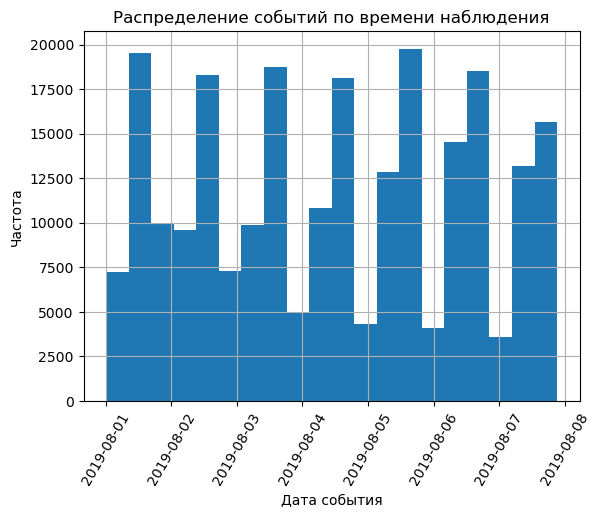

In [47]:
actual_data['event_time'].hist(bins=20)
plt.title('Распределение событий по времени наблюдения')
plt.xlabel('Дата события')
plt.ylabel('Частота')
plt.xticks(rotation=60)
plt.show()

На самом деле мы располагаем данными с 1 по 7 августа 2019 года

### Оценка потери отсеченных данных

Много ли событий и пользователей мы потеряли, отбросив старые данные? Для этого сделаем точно такие же рассчеты по количеству уникальных пользователей и количеству событий, только с новым датафреймом. 

In [48]:
actual_data['event_type'].count()

240887

In [49]:
data['event_type'].count()-actual_data['event_type'].count()

2826

In [50]:
100 - (actual_data['event_type'].count()/data['event_type'].count()*100)

1.1595606307418933

В количестве событий - мы потеряли 2 826 шт событий или 1.15% от общего количества.

In [51]:
actual_data['user_id'].nunique()

7534

In [52]:
data['user_id'].nunique()-actual_data['user_id'].nunique()

17

In [53]:
100-(actual_data['user_id'].nunique()/data['user_id'].nunique()*100)

0.22513574361011024

В количестве уникальных пользователей - мы потеряли 17 уникальных пользователей или 0.22% от общего количества.

Общие потери данных как в количестве пользователей, так и в количестве событий минимальны и допустимы.

### Сравнение экспериментальных групп

#### Количество событий в экспериментальных группах

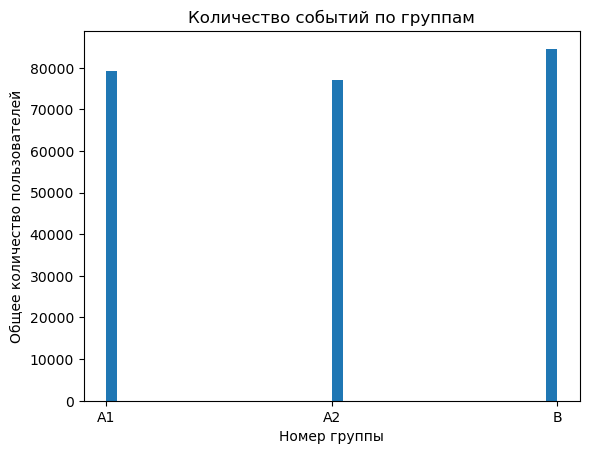

In [54]:
plt.hist(actual_data['group'], bins = 40)
plt.title('Количество событий по группам')
plt.xlabel('Номер группы')
plt.ylabel('Общее количество пользователей')
plt.show()

In [55]:
len(actual_data[actual_data['group']=='A1'])

79302

In [56]:
len(actual_data[actual_data['group']=='A2'])

77022

In [57]:
len(actual_data[actual_data['group']=='B'])

84563

Выше мы смотрели количество совершенных событий в каждой группе.
Теперь посмотрим, сколько уникальных пользователей есть в каждой группе.

#### Количество пользователей в экспериментальных группах

In [58]:
actual_data.groupby('group')['user_id'].nunique()

group
A1    2484
A2    2513
B     2537
Name: user_id, dtype: int64

#### Сравнение группы A1 и A2

Сделаем таблицу с количеством пользователей по группам и сравним разницу между группой А1 и А2

In [59]:
user_group = actual_data.groupby('group')['user_id'].nunique()
user_group['A'] = user_group['A1'] + user_group['A2']
user_group

group
A1    2484
A2    2513
B     2537
A     4997
Name: user_id, dtype: int64

In [60]:
user_group['A1']/user_group['A2']*100

98.84600079586153

In [61]:
user_group['A2']/user_group['A1']*100

101.16747181964574

Различия между группами А1 и А2 в количестве составялют 1.16% - такой процент допустим, считаем, что группы контроля сформированы верно, то есть сбалансрованны.

## Воронка событий

### Какае события есть в логах, их частота. Сортировка событий по частоте

In [62]:
actual_event = pd.DataFrame()
actual_event['type_event'] = actual_data.groupby('event_type')['user_id'].count()
actual_event['persent'] = ((actual_event['type_event'] / actual_data['event_type'].count()) * 100)
actual_event.sort_values(by='persent', ascending=False).style.format({'persent': '{:.2f}%'})

,type_event,persent
event_type,,
MainScreenAppear,117328,48.71%
OffersScreenAppear,46333,19.23%
CartScreenAppear,42303,17.56%
PaymentScreenSuccessful,33918,14.08%
Tutorial,1005,0.42%


### Визуализация частоты событий

In [64]:
fig = go.Figure(data=[go.Pie(labels=actual_data['event_type'].value_counts().index, values=actual_data['event_type'].value_counts(), \
                             title='Частота событий')])
fig.show()

### События по числу пользователей 

Посчитаем, сколько пользователей совершали каждое из этих событий и долю пользователей для каждого действия в отношении к первоначальному количеству пользователей. 

In [66]:
actual_event_for_user = actual_data.groupby('event_type').agg({'user_id':'nunique'}).reset_index()
actual_event_for_user.set_axis(['type_event', 'number_users'], axis='columns', inplace=True)
actual_event_for_user['persent'] = actual_event_for_user.number_users/actual_data['user_id'].nunique()*100
actual_event_for_user = actual_event_for_user.sort_values('number_users', ascending=False).reset_index(drop=True)

# построим воронку
actual_event_for_user['funnel'] = 1
for i in range(1, 4):
    actual_event_for_user.loc[i, 'funnel'] = actual_event_for_user.loc[i, 'number_users'] /  (actual_event_for_user.loc[i-1, 'number_users'])

actual_event_for_user

C:\Users\NADYA-PC\AppData\Local\Temp\ipykernel_4624\2931460678.py:2: FutureWarning:

DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead



,type_event,number_users,persent,funnel
0,MainScreenAppear,7419,98.473586,1.000000
1,OffersScreenAppear,4593,60.963632,0.619086
2,CartScreenAppear,3734,49.561986,0.812976
3,PaymentScreenSuccessful,3539,46.973719,0.947777
4,Tutorial,840,11.149456,1.000000


### Порядок событий

Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? 

Предполагаю, что все упомянутые события происходят последовательно и выстраиваются в цепочку за исключением события Tutorial (обучение). Предполагаю, что событие Tutorial (обучение) не обязательно нужно для формления успешной покупки.

Соответственно, предполагаю, что событие Tutorial (обучение) в расчете воронки не требуется учитывать.

По воронке событий видим, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).
При переходе от страницы главного экрана до экрана с товаром теряется большинство пользователей - порядка 38%

От первого события до оплаты проходит 46,9% пользователей


### Построение графика воронки

In [68]:
funnel_event = dict(
    number=[98.47, 60.96, 49.56, 46.97],
    stage=["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"])
fig = px.funnel(funnel_event, x='number', y='stage')
fig.update_layout(title='Распределение событий по времени наблюдения', title_x =0.5)
fig.show()

## Изучение результатов эксперимента

### Количество пользователей в экспериментальных группах

In [47]:
actual_data.groupby('group')['user_id'].nunique()

group
A1    2484
A2    2513
B     2537
Name: user_id, dtype: int64

### Проверка пользователей на наличие в разных экспериментальных группах

In [72]:
(actual_data.groupby('user_id')['group'].nunique() > 1).sum()

0

In [73]:
actual_data

,event_type,user_id,event_time,group,event_data
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,A1,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,A1,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,A1,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,A1,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,A2,2019-08-01
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,A2,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,A1,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,A1,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,A1,2019-08-07


### Cтатистические критерии разницу между выборками A1 и A2.

Сделаем таблицу с количеством пользователей по группам с разбивкой по событиям

In [74]:
event_group_test = actual_data[actual_data['event_type']!='Tutorial'].pivot_table(
    index='event_type', 
    columns='group', 
    values='user_id',
    aggfunc='nunique').sort_values(by='A1', ascending=False)

event_group_test = event_group_test.reset_index()
event_group_test['A'] = event_group_test['A1'] + event_group_test['A2']
event_group_test['all'] = event_group_test['A'] + event_group_test['B']

event_group_test['part_A1'] = (event_group_test['A1'] / user_group['A1'] * 100).round(1)
event_group_test['part_A2'] = (event_group_test['A2'] / user_group['A2'] * 100).round(1)
event_group_test['part_B'] = (event_group_test['B'] / user_group['B'] * 100).round(1)
event_group_test['part_A'] = ((event_group_test['A1'] + event_group_test['A2']) / \
                                  (user_group['A1'] + user_group['A2']) * 100).round(1)
# event_group_test['part_all'] = (event_group_test['all'] / users_bygroup.sum() * 100).round(1)
event_group_test

group,event_type,A1,A2,B,A,all,part_A1,part_A2,part_B,part_A
0,MainScreenAppear,2450,2476,2493,4926,7419,98.6,98.5,98.3,98.6
1,OffersScreenAppear,1542,1520,1531,3062,4593,62.1,60.5,60.3,61.3
2,CartScreenAppear,1266,1238,1230,2504,3734,51.0,49.3,48.5,50.1
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539,48.3,46.1,46.6,47.2


Проверим, есть ли статистические критерии разницу между выборками 246 (А1) и 247 (А2).

Для этого напишем формулу

Проверка статистической разницы, это проверка гипотезы. Мы проверяем статистическую разницу между группами А1 и А2. Нулевая гипотеза звучит так "Группа А1 и А2 одинаковые, между ними нет значимой статистической разницы" Альтернативная гипотеза звучит так "Группа А1 и А2 не одинаковые, между ними есть значимая статистическая разница".

In [75]:
def aa_test(group1, group2, alpha):
    for i in event_group_test.index:
        # пропорция успехов в первой группе:
        p1 = event_group_test[group1][i] / user_group[group1]
        # пропорция успехов во второй группе:
        p2 = event_group_test[group2][i] / user_group[group2]
        
        print(event_group_test[group1][i],event_group_test[group2][i], user_group[group1], user_group[group2])
        # пропорция успехов в комбинированном датасете:
        p_combined = ((event_group_test[group1][i] + event_group_test[group2][i]) / 
                      (user_group[group1] + user_group[group2]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/user_group[group1] + 1/user_group[group2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(event_group_test['event_type'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')
        
aa_test("A1", "A2", 0.01)

2450 2476 2484 2513
MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1542 1520 2484 2513
OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1266 1238 2484 2513
CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1200 1158 2484 2513
PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Между выборками 246 (А1) и 247 (А2) нет статистической разницы

### Выбор самого популярного события

In [76]:
actual_data['event_type'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_type, dtype: int64

Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. 

In [77]:
event_group_test

group,event_type,A1,A2,B,A,all,part_A1,part_A2,part_B,part_A
0,MainScreenAppear,2450,2476,2493,4926,7419,98.6,98.5,98.3,98.6
1,OffersScreenAppear,1542,1520,1531,3062,4593,62.1,60.5,60.3,61.3
2,CartScreenAppear,1266,1238,1230,2504,3734,51.0,49.3,48.5,50.1
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539,48.3,46.1,46.6,47.2


### Cтатистические критерии разницу между выборками A1/B, A2/B, A/B

Проверьте, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий.

Так как группу А1 и А2 мы проверяли ранее между собой, сделаем следующую сверку - А1/В; А2/В и А1+А2/В

Мы проверяем статистическую разницу между группами А1 и B. Нулевая гипотеза звучит так "Группа А1 и B одинаковые, между ними нет значимой статистической разницы" Альтернативная гипотеза звучит так "Группа А1 и B не одинаковые, между ними есть значимая статистическая разница".

In [78]:
aa_test("A1", "B", 0.01)

2450 2493 2484 2537
MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1542 1531 2484 2537
OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1266 1230 2484 2537
CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1200 1181 2484 2537
PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Мы проверяем статистическую разницу между группами А2 и B. Нулевая гипотеза звучит так "Группа А2 и B одинаковые, между ними нет значимой статистической разницы" Альтернативная гипотеза звучит так "Группа А2 и B не одинаковые, между ними есть значимая статистическая разница".

In [79]:
aa_test("A2", "B", 0.01)

2476 2493 2513 2537
MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1520 1531 2513 2537
OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1238 1230 2513 2537
CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1158 1181 2513 2537
PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Мы проверяем статистическую разницу между группами А1+A2 и B. Нулевая гипотеза звучит так "Группа А1+A2 и B одинаковые, между ними нет значимой статистической разницы" Альтернативная гипотеза звучит так "Группа А1+A2 и B не одинаковые, между ними есть значимая статистическая разница".

In [54]:
aa_test('A', "B", 0.01)

4926 2493 4997 2537
MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

3062 1531 4997 2537
OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

2504 1230 4997 2537
CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

2358 1181 4997 2537
PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Можно сделать вывод, что разбиение на группы работает корректно.

Можно сделать вывод, что статистически значимых различий между группами мы не обнаружили.

При проверке гипотез мы выбрали более жесткий уровень статистической значимости - 0.01

В ходе исследования мы сделали 16 проверок статистических гипотез (4 сравнения групп по 4 параметрам каждая).

### Поправка Бонферонни

Мы сделаем корректировку через поправку Бонферонни. Формула поправки выглядит вот так - "α новый = α исходный / n". n = 16, значит новый уровень статистической значимости равен = 0,01/16 = 0,000625. Проведем все проверки гипотез с таким уровнем значимости. 

In [80]:
aa_test("A1", "A2", 0.000625)

2450 2476 2484 2513
MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1542 1520 2484 2513
OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1266 1238 2484 2513
CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1200 1158 2484 2513
PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [81]:
aa_test("A1", "B", 0.000625)

2450 2493 2484 2537
MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1542 1531 2484 2537
OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1266 1230 2484 2537
CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1200 1181 2484 2537
PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [82]:
aa_test("A2", "B", 0.000625)

2476 2493 2513 2537
MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1520 1531 2513 2537
OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1238 1230 2513 2537
CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1158 1181 2513 2537
PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [83]:
aa_test("A", "B", 0.000625)

4926 2493 4997 2537
MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

3062 1531 4997 2537
OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

2504 1230 4997 2537
CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

2358 1181 4997 2537
PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Мы провели все тесты с новым, скорректированным уровнем значимости - результаты не изменились. Между группами нет статистически значимых различий

Финальный вывод - в результате недельного исследования активности пользователей в приложении при использовании версии со старым и новым шрифтом статистически значимых различий не выявлено.

## Выводы по проделанной работе

### Подготовка и анализ данных

Первичный анализ сырых данных показал следующее - было 413 строчек дубликатов, мы их удалилили из анализа. По времени эксперимента данные предоставлены с 25 июля 2019 года по 31 августа 2019 года - при узучении пользовательской активности выявлено, что до 1 августа 2019 года активность пользователей была крайне низкой. Для более корректного анализа мы откинули всю информацию до 1 августа 2019 года. После "очистки" данных от дубликатов и неактивного времени мы получили данные со следующим содержанием - 7 551 уникальных пользователя, 243 713 событий за период, 5 типов событий, 4 из которых связаны между собой. Три целевые группы пользователей, распределенных на время эксперимента равномерно. 

### Воронка событий

В данных есть пять событий. Четыре из них логически связаны между собой и идут последовательно (MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful). Событие Tutorial независимо от других событий, не является целевым действием - при построении воронки событий мы исключаем эти события из анализа. Самое пополярное событие - MainScreenAppear - на него приходится почти половина всех действий во время эксперимента. После построения вороки событий мы можем сделать вывод, что от 100% пользователей до доиента оплаты (PaymentScreenSuccessful) доходят 47% пользователей. Больше всего пользователей теряется при переходе с шага MainScreenAppear на шаг OffersScreenAppear - порядка 38%

### Результаты эксперимента

Пользователи распределены равномерно по двум контрольным и одной экспериментальной группе. Для начала мы проверили между собой две контрольные группы - так мы проверяем механизм распределения - статистических различий при уровне значимости 0.01 не обнаружено. Далее мы последовательно сравнили контрольные группы с экспериментальной - статистических различий при уровне значимости 0.01 не обнаружено. Так как мы проводим 16 проверок гипотез в рамках одного датасета, вероятность получить «ложноположительный» результат так же возрастает в 16 раз - что бы исключить верояность «ложноположительного» результата мы сделали поправку Бонферонни для статистической значимости и снова провели 16 тестов. Итоговый результат - статистическо значимой разницы между контрольными и экспериментальной группами не выявлено. 
Это значит что пользователи приложения со старым и новым шрифтом ведут себя одинаково - шрифт не поменял пользовательскую активность.
Следовательно мы можем сделать обоснованный вывод, что переводить приложение полностью на новый шрифт можно - пользователи одинаково ориентируются в функциях приложения при новой версии шрифта так же хорошо, как и при старой.